# Statistical models

In the notebook `01_Data_Exploration` we have identified a trend of increasing sales over the years as well as seasonality within both years and weeks.

To predict the next three month of sales we will try statistical models in this notebook.

We use the Autoregressive Integrated Moving Average (ARIMA) to capture the trend. Finally, we utilize the Seasonal Autoregressive Integrated Moving-Average (SARIMA).

We conclude with a summary and recommendations for the next steps.

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
## Load data and convert datatypes
data = pd.read_csv("./data/train.csv")
data['date'] = pd.to_datetime(data['date'])

## Split into train and testing data
## Use the last 3 month (Oct-Dec 2017) as testing data. The rest is training data.
train = data.loc[data['date'] < '2017-10-01' ]
test = data.loc[data['date'] >= '2017-10-01' ]

We choose this split so that we can use an intact sequence for training. The downside is that we want to predict the three month in the future after the available training data. Using the last remaining three month from training for testing means they are not used in the training. That's why we could, after testing, include them to update the model. Another way could be to break up the sequence and use for example a year as testing data. This would be justified through the seasonality on the year scale, see previous notebook.

In [3]:
## Sales for store 4 and item 7. Name is sales_store_item:
def get_sales(store, item):  
    sales_train = train.loc[train['store'] == int(store)].loc[train['item'] == int(item)]
    dates_train = sales_train['date'].dt.strftime('%Y-%m-%d')
    sales_train = sales_train['sales'].tolist()
       
    sales_test = test.loc[test['store'] == int(store)].loc[test['item'] == int(item)]
    dates_test = sales_test['date'].dt.strftime('%Y-%m-%d')
    sales_test = sales_test['sales'].tolist()
      
          
    return sales_train, dates_train, sales_test, dates_test
       
    
sales_train, dates_train, sales_test, dates_test = get_sales(4, 7)

In [4]:
def plot_sales_per_store_item(test_data, pred, dates):
    plt.figure(figsize=[20,10])
    dates = dates
    
    plt.plot(dates, test_data, color="navy", label='truth')
    plt.plot(dates, pred, color="green", label='prediction')
    plt.title("Prediction and ground truth")
    plt.xticks(np.arange(0, len(test_data), 10))
    plt.xlabel("Date")
    plt.ylabel("Sales [-]")
    plt.legend()
    plt.show()

### 1. Autoregressive Integrated Moving Average (ARIMA)
ARIMA is a combination of the autoregression model AR(p), the moving average MA(q) and an integral part I(d). The I makes it suitable for data with a trend.



The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps [1]. 

It is suited for data without trends and seasonal components. That is why we should first decompose our signal into trend, seasonality. As has been shown in the previous notebook, there is a clear trend on a month scale and a weaker trend on the year scale. To simplify things we will not remove the trend here.






It is not suited for seasonal components but is able to capture a trend.

ARIMA(p,d,q)

p: Number of lags included in model

d: Number of differenciation performed

q: Window size for moving average


How to determine parameters:
p:



See also: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

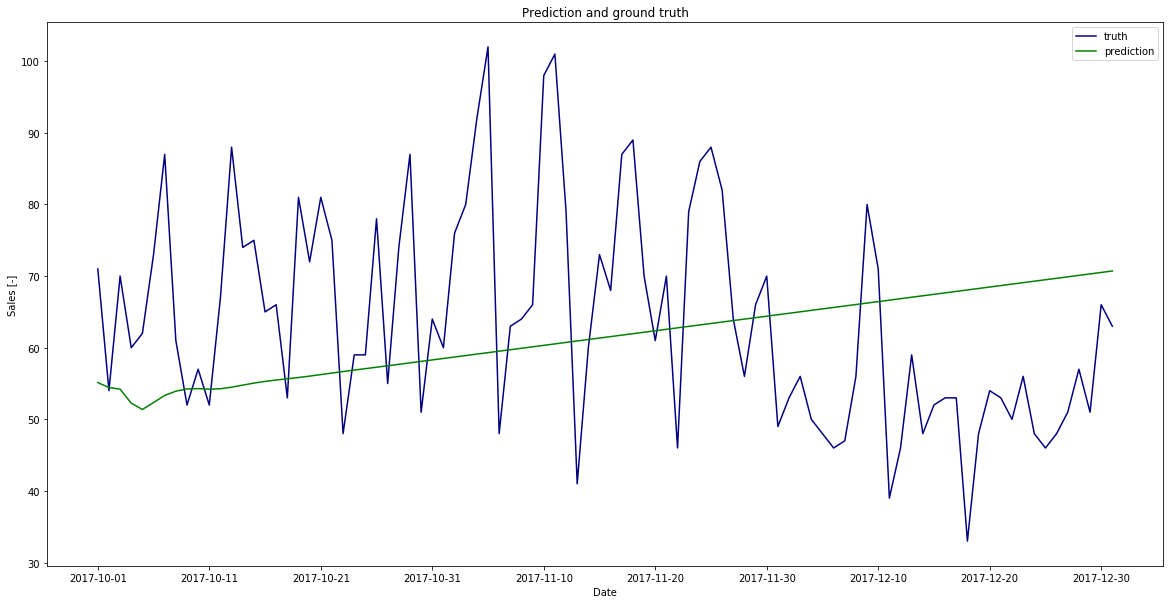

In [6]:
## Get data for store 4 and item 7:
train_4_7, dates_train, test_4_7, dates_test = get_sales(4, 7)

train_4_7 = train_4_7[0:100]
test_4_7 = test_4_7[0:100]
dates_test = dates_test[0:100]

# Fit model
model = ARIMA(train_4_7, order=(5, 1, 2))
model_fit = model.fit(disp=0)

# Predict
start = len(train_4_7)
end = len(train_4_7) + len(test_4_7) - 1

## In order to get the predicted values in original scale we use the type 'levels'
pred_arima = model_fit.predict(start, end, typ='levels')


plot_sales_per_store_item(test_4_7, pred_arima, dates_test)

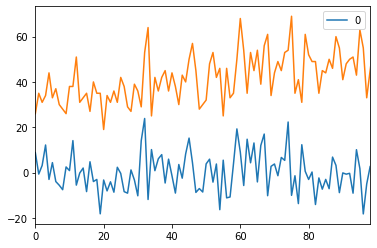

In [80]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.plot(train_4_7)

predicted=55.136013, expected=71.000000
predicted=54.922351, expected=54.000000
predicted=51.320522, expected=70.000000
predicted=49.861481, expected=60.000000
predicted=48.952191, expected=62.000000
predicted=48.382724, expected=73.000000
predicted=64.769731, expected=87.000000
predicted=75.440433, expected=61.000000
predicted=81.344969, expected=52.000000
predicted=72.656216, expected=57.000000
predicted=67.563790, expected=52.000000
predicted=57.921331, expected=67.000000
predicted=66.929903, expected=88.000000
predicted=74.534577, expected=74.000000
predicted=63.975580, expected=75.000000
predicted=62.935334, expected=65.000000
predicted=61.166144, expected=66.000000
predicted=63.923393, expected=53.000000
predicted=69.826865, expected=81.000000
predicted=79.468114, expected=72.000000
predicted=77.457642, expected=81.000000
predicted=73.198593, expected=75.000000
predicted=72.471000, expected=48.000000
predicted=59.125698, expected=59.000000
predicted=66.380062, expected=59.000000


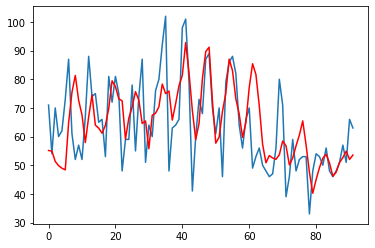

In [82]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


train = train_4_7
test = test_4_7

size = int(len(train + test) * 0.66)

history = [x for x in train]
predictions = list()

for t in range(len(test)):
	model = ARIMA(history, order=(5,1,2))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

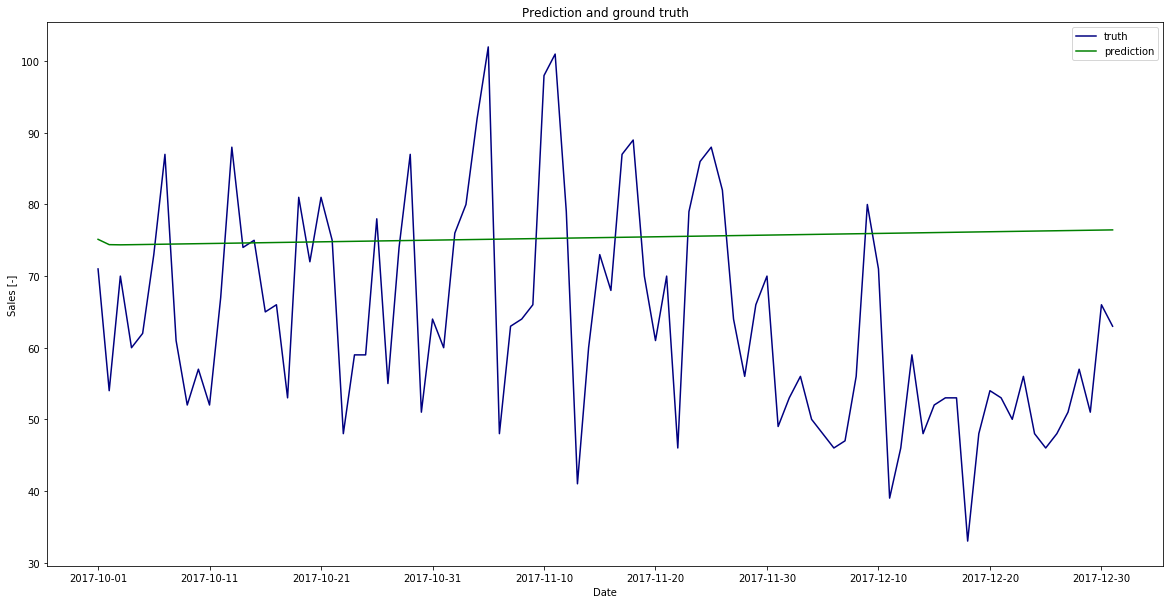

In [11]:
plot_sales_per_store_item(test_4_7, pred_arima, dates_test)

### 2. Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [92]:
## Get data for store 4 and item 7:
train_4_7, dates_train, test_4_7, dates_test = get_sales(4, 7)

## Fit model
model = SARIMAX(train_4_7, order=(1, 1, 1), seasonal_order=(1, 2, 2, 2))
model_fit = model.fit(disp=False)

## Predict
start = len(train_4_7)
end = len(train_4_7) + len(test_4_7) - 1

pred_sarima = model_fit.predict(start, end)

ValueError: non-invertible starting seasonal moving average parameters found with `enforce_invertibility` set to True.

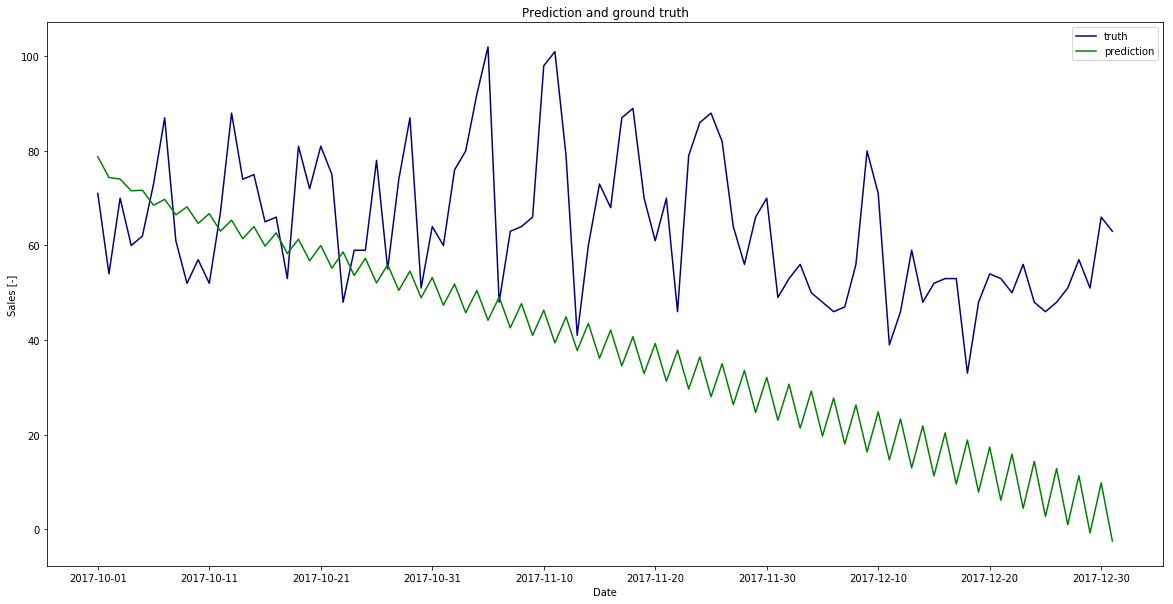

In [88]:
plot_sales_per_store_item(test_4_7, pred_sarima, dates_test)

## Conclusion

The data has both seasonality on more than one scale as well as a trend. That is the reason why the three statistical models tried in this notebook are not capable of predicting future sales well. Slightly better results could be achieved with more data preparation like properly removing seasonality and trend. However, we will move on to machine learning models which are able to perform much better on this task.


Try: Long memory time series

# References

[1] Bownlee, Jason. *11 Classical Time Series Forecasting Methods in Python*. 2018. Accessed on 15/02/2020 [Link](https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/)

[2] Cryer, Chan. *Time Series Analysis*. 2008

[3] https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/